# Evaluate BERT for OSC

In [1]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertTokenizerFast, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils.data_helper import read_mag_file
from utils.lazydataset import LazyTextMAG_OSC_Dataset

In [2]:
save_pkl_root = '/home/datamerge/ACL/Data/210422/pkl/'
save_train_root = '/home/datamerge/ACL/Data/210422/train/'
save_test_root = '/home/datamerge/ACL/Data/210422/test/'
save_open_root = '/home/datamerge/ACL/Data/210422/open/'
save_dev_root = '/home/datamerge/ACL/Data/210422/dev/'

afid2nor = pickle.load(open(save_pkl_root+"afid2nor.pkl", "rb"))
nor2afid = pickle.load(open(save_pkl_root+"nor2afid.pkl", "rb"))

In [3]:
overall_mid2label_dict = { i: nor for i, (afid, nor) in enumerate(afid2nor.items())}
overall_label2mid_dict = { v: k for k,v in overall_mid2label_dict.items()}

In [4]:
nor2len_dict = pickle.load(open(save_pkl_root+'210422_nor2len_dict.pkl', 'rb'))

train_mid2label_dict = pickle.load(open(save_pkl_root+'train_mid2label_dict.pkl', 'rb'))
train_label2mid_dict = pickle.load(open(save_pkl_root+'train_label2mid_dict.pkl', 'rb'))

overall_mid2label_dict = pickle.load(open(save_pkl_root+'overall_mid2label_dict.pkl', 'rb'))
overall_label2mid_dict = pickle.load(open(save_pkl_root+'overall_label2mid_dict.pkl', 'rb'))

train_mid2overall_mid = {train_id: overall_label2mid_dict[train_label]  for train_id, train_label in train_mid2label_dict.items()}

In [5]:
osc_filepath = save_test_root+'test_osc.txt'

In [6]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

osc_test_dataset = LazyTextMAG_OSC_Dataset(tokenizer, osc_filepath, overall_label2mid_dict)

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

class BertForAffiliationNameNormalization(torch.nn.Module):
    
    def __init__(self, num_of_classes):
        super(BertForAffiliationNameNormalization, self).__init__()
        self.num_of_classes = num_of_classes
        self.bert = BertModel.from_pretrained('bert-base-uncased').to(device)
        self.dropout = nn.Dropout(p=0.1, inplace=False).to(device)
        self.classifier = nn.Linear(self.bert.config.hidden_size, self.num_of_classes, bias=True).to(device)
        
        
    def forward(self, input_ids, attention_mask):
        pooled_out = self.bert(input_ids, attention_mask=attention_mask)
        pooled_out = self.dropout(pooled_out[1])
        logits = self.classifier(pooled_out)
        
        return logits

In [8]:
model = torch.load('./checkpoint0422/After_epoch_79_bert.pkl')

In [9]:
def report_osc(y, scores):
    fpr, tpr, thresholds = roc_curve(y, scores)  
    return fpr, tpr, thresholds


def calc_split(low_margin, high_margin, y, scores, test_set_size):
    low = test_set_size < low_margin
    high = test_set_size > high_margin
    mid = np.logical_and(test_set_size >= low_margin, test_set_size <= high_margin)

    r1 = report_osc(y[high], scores[high])
    r2 = report_osc(y[mid], scores[mid])
    r3 = report_osc(y[low], scores[low])
    
    return r1, r2, r3

In [10]:
def evaluate_osc(model, dataset, nor2len_dict, overall_mid2label_dict, threshold):
    model.eval()
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#     model = nn.DataParallel(model, device_ids=[0,1,2,3])
#     model.to(torch.device('cuda:1'))
    
    test_dataset = dataset
    loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)
    true = []         
    pred = []         
    open_labels = []  
    pred_open_labels = [] 
    probability = []  
    test_set_size = []
    
    i = 0
    for batch in tqdm(loader):
        input_ids = torch.cat([i.reshape(1,-1) for i in batch['input_ids']], dim=0).to(device)
        attention_mask = torch.cat([i.reshape(1,-1) for i in batch['attention_mask']], dim=0).to(device)
        label = batch['label'].to(device)
        open_label = batch['open_label'].to(device)
        
        logits = model(input_ids, attention_mask=attention_mask)
        probs = F.softmax(logits, dim=1)
#         print(probs)
#         print(probs.shape)
        max_prob = torch.max(probs, 1)[0]
        preds = logits.argmax(-1).tolist()
        preds = torch.tensor([train_mid2overall_mid[train_mid] for train_mid in preds])
        
        tmp_test_size = [nor2len_dict[overall_mid2label_dict[label_id.item()]]  for label_id in label]
        test_set_size = test_set_size + tmp_test_size
        
        true.append(label.to(torch.device('cpu')))
        open_labels.append(open_label.to(torch.device('cpu')))
        pred.append(preds[:len(label)].to(torch.device('cpu')))
        probability.append(max_prob.detach().to(torch.device('cpu')))

    pred = torch.cat(pred).numpy()
    true = torch.cat(true).numpy() 
    open_labels = torch.cat(open_labels).numpy()
    probability = 1 - torch.cat(probability).numpy()
    pred_open_labels = 1 - (probability >= threshold)
    
    test_set_size = np.array(test_set_size)
    fpr, tpr, thresholds = report_osc(open_labels, probability)

    overall = {
        'fpr': fpr,
        'tpr': tpr,
    }
    high, middle, few = calc_split(5, 20, open_labels, probability, test_set_size)
    part = {
        'high':{
            'fpr': high[0],
            'tpr': high[1],
        },
        'middle':{
            'fpr': middle[0],
            'tpr': middle[1],
        }, 
        'few':{
            'fpr': few[0],
            'tpr': few[1],
        },     
    }
    return (overall, part)

In [11]:
overall, part = evaluate_osc(model, osc_test_dataset, nor2len_dict, overall_mid2label_dict, 0.8)

100%|██████████| 402/402 [03:41<00:00,  1.82it/s]


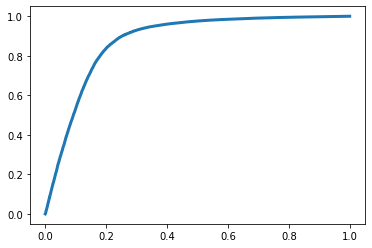

In [12]:
from matplotlib import pyplot as plt

plt.plot(overall['fpr'], overall['tpr'], label="BERT Overall",  linewidth=3, linestyle='-')
plt.show()

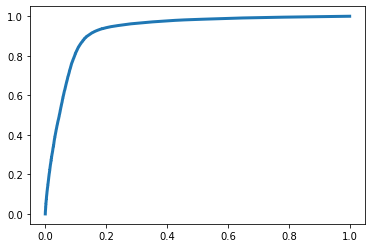

In [13]:
plt.plot(part['high']['fpr'], part['high']['tpr'], label="BERT Overall",  linewidth=3, linestyle='-')
plt.show()

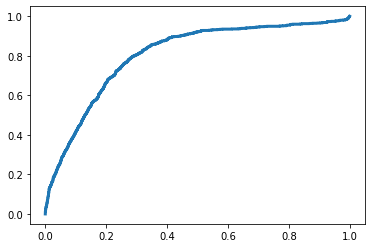

In [14]:
plt.plot(part['middle']['fpr'], part['middle']['tpr'], label="BERT Overall",  linewidth=3, linestyle='-')
plt.show()

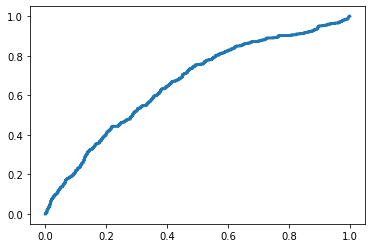

In [15]:
plt.plot(part['few']['fpr'], part['few']['tpr'], label="BERT Overall",  linewidth=3, linestyle='-')
plt.show()

In [16]:
result = {
    'overall': overall,
    'part': part
}

pickle.dump(result, open("./osc/osc_original.pkl", 'wb'))